In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
#plot_confusion_matrix deprecated

In [4]:
# Se resultado atual ficar muito inferior, 
# Falta grid search no tamanho dos embeddigns
    # Falta hyperopt dos parametros do random forest

In [5]:
#embedding_model = Word2Vec.load('gensim/f2086855_mc1_W5_S64_samp0_a0.03_mina0.0007_n20_seed42_epoch5.model')
embedding_model = Word2Vec.load('gensim/word2vec.model')
def get_line_embedding(line):
    if line == '' or line == None:
        return np.zeros((1,64))
    try:
        avg_line_vector = np.zeros((1,64))
        tokens = line.split(' ')
        for token in tokens:
            avg_line_vector = avg_line_vector + embedding_model.wv[token]
    except Exception as e:
        print(line)
        print(e)
    return avg_line_vector / len(tokens)

def get_vocab_average():
    vectors = embedding_model.wv.vectors
    column_sums = np.sum(vectors, axis=0)
    column_sums = column_sums / vectors.shape[0]
    return column_sums * 0.01

vocab_average = get_vocab_average()
def add_perturbation(sample):
    for line in ['m2', 'm1', '0', '1', '2']:
        sample['vector_{}'.format(line)] += vocab_average
    return sample

In [6]:
# Apply only to the train dataset, test must be kept with real world proportion
# Upsampling procedure
# 1. upsampling from each SonarQube type until we achieved even distribution of true and false positives within that warning type
# 2. upsampling by adding some noise to randomly selected instances from the minority class
# 3. upsampling true positives
# 4. for each randomly selected instance from a particular warning type the 1% of the vocabulary average has been added.
def upsample_by_squid(df):
    squids = df['squid'].unique()
    for squid in squids:
        try:
            true_issues = df[(df['squid'] == squid)&(df['cls'] == 0)].shape[0]
            false_issues = df[(df['squid'] == squid)&(df['cls'] == 1)].shape[0]
            upsample = abs(true_issues - false_issues)
            if false_issues > true_issues:
                minority_samples = resample(df[(df['squid'] == squid)&(df['cls'] == 0)], n_samples = upsample)
            elif false_issues < true_issues:
                minority_samples = resample(df[(df['squid'] == squid)&(df['cls'] == 1)], n_samples = upsample)
            else:
                continue
            minority_samples = minority_samples.apply(add_perturbation, axis=1)
            df = pd.concat([df, minority_samples], axis=0)
        except:
            print(true_issues, false_issues, upsample)
    return df

In [7]:
# Data loading

In [8]:
full_dataset = pd.read_csv('main_dataset.csv')
full_dataset['token_line_m2'].fillna('', inplace=True)
full_dataset['token_line_m1'].fillna('', inplace=True)
full_dataset['token_line_0'].fillna('', inplace=True)
full_dataset['token_line_1'].fillna('', inplace=True)
full_dataset['token_line_2'].fillna('', inplace=True)

In [9]:
# Add vectors for each line in the context
for line in ['m2', 'm1', '0', '1', '2']:
    full_dataset['vector_{}'.format(line)] = full_dataset['token_line_{}'.format(line)].apply(get_line_embedding)

In [10]:
# Create one hot encoding for column squid
full_dataset = pd.concat([full_dataset, one_hot_encoded], axis=1)

In [11]:
# full_dataset['tokens'] = full_dataset['token_line_m2'].fillna('') + ' ' +  full_dataset['token_line_m1'].fillna('') +  ' ' +  full_dataset['token_line_0'].fillna('') +  ' ' +  full_dataset['token_line_1'].fillna('')  +  ' ' +  full_dataset['token_line_2'].fillna('')
# tokens = full_dataset['tokens'].tolist()
# tokens = [ x.split(' ') for x in tokens] 
# tokens = [ list(set(x)) for x in tokens ] 
# tokens = [item for sublist in tokens for item in sublist]
# tokens = [ x for x in tokens if len(x) > 0 ] 
# tokens = list(set(tokens))
# tokens.sort()
# tokens

In [16]:
# 80-10-10% ratio for training, hyper-parameter optimization, and testing
X_train, X_test, Y_train, Y_test = train_test_split(full_dataset, full_dataset['cls'], test_size=0.10, stratify=full_dataset['squid'])

In [17]:
X_train = upsample_by_squid(X_train)

squid_S2208
squid_S1192
squid_S1186
squid_S1166
squid_S1214
squid_S2447
squid_S2333
squid_S1068
squid_S1197
squid_S1132
squid_S1125
squid_S1213
squid_S2259
squid_S1155
squid_S2153
squid_S1149
squid_S00115
squid_S2325
squid_S106
squid_S00107
squid_S00103
squid_S1181
squid_S00108
squid_S00112
squid_CommentedOutCodeLine
squid_S00100
squid_S00116
squid_UselessImportCheck
squid_S1602
squid_ClassVariableVisibilityCheck
squid_S1066
squid_S1444
squid_S1135
squid_S2293
squid_S1481
squid_S2039
squid_S2156
squid_S1941
squid_S00122
squid_S2974
squid_S1319
squid_SwitchLastCaseIsDefaultCheck
squid_S1118
squid_S1845
squid_S2386
squid_MethodCyclomaticComplexity
squid_S1168
squid_S1215
squid_S1948
squid_S1943
squid_S1905
squid_S2142
squid_S00119
squid_S1312
squid_MissingDeprecatedCheck
squid_S2696
squid_S1596
squid_S00120
squid_S2864
squid_S2183
squid_HiddenFieldCheck
squid_S2147
squid_S00117
squid_S128
squid_AssignmentInSubExpressionCheck
squid_S2111
squid_S1148
squid_S1199
squid_S2786
squid_S1694
squ

In [18]:
features = ['vector_m2', 'vector_m1', 'vector_0', 'vector_1', 'vector_2'] + one_hot_encoded.columns.tolist()
x_train = X_train[features]
y_train = X_train['cls']
x_test = X_test[features]
y_test = X_test['cls']

In [132]:
def convert_dataframe_to_numpy(df):
    n_rows = df.shape[0]
    matrix = np.empty((0, 5 * 64))
    rows = []
    for i in range(n_rows):
        if (i + 1) % 50000 == 0:
            print(100 * i/(1.0 *n_rows))
        single_line = []
        for feature in ['m2', 'm1', '0', '1', '2']:
            single_line += [ df.iloc[i]['vector_{}'.format(feature)][0].tolist() ]
        rows += [ np.array(single_line).reshape(1, -1) ]
    matrix = np.vstack(rows)
    matrix = np.concatenate([matrix, df[one_hot_encoded.columns.tolist()].values], axis=1)
    return matrix

In [133]:
x_train = convert_dataframe_to_numpy(x_train)

13.160194353637287
26.32065191642583
39.481109479214375
52.64156704200292
65.80202460479146
78.96248216758
92.12293973036854


In [134]:
x_test = convert_dataframe_to_numpy(x_test)

In [144]:
y_test.value_counts()

cls
1    17756
0     4693
Name: count, dtype: int64

In [36]:
# Final step, model trained with the best parameters

In [7]:
x_train = pd.read_csv('input/x_train.csv', header=None)
y_train = pd.read_csv('input/y_train.csv', header=None)

x_test = pd.read_csv('input/x_test.csv', header=None)
y_test = pd.read_csv('input/y_test.csv', header=None)

In [139]:
clf = RandomForestClassifier(criterion='entropy', max_depth=100, max_features=480, min_samples_leaf=1, min_samples_split=10, n_estimators=250, verbose=3,n_jobs=4)
clf.fit(x_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 250building tree 2 of 250
building tree 3 of 250

building tree 4 of 250
building tree 5 of 250
building tree 6 of 250
building tree 7 of 250
building tree 8 of 250
building tree 9 of 250
building tree 10 of 250
building tree 11 of 250
building tree 12 of 250
building tree 13 of 250
building tree 14 of 250
building tree 15 of 250
building tree 16 of 250
building tree 17 of 250
building tree 18 of 250
building tree 19 of 250
building tree 20 of 250
building tree 21 of 250
building tree 22 of 250
building tree 23 of 250
building tree 24 of 250
building tree 25 of 250
building tree 26 of 250
building tree 27 of 250
building tree 28 of 250


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  4.7min


building tree 29 of 250
building tree 30 of 250
building tree 31 of 250
building tree 32 of 250
building tree 33 of 250
building tree 34 of 250
building tree 35 of 250
building tree 36 of 250
building tree 37 of 250
building tree 38 of 250
building tree 39 of 250
building tree 40 of 250
building tree 41 of 250
building tree 42 of 250
building tree 43 of 250
building tree 44 of 250
building tree 45 of 250
building tree 46 of 250
building tree 47 of 250
building tree 48 of 250
building tree 49 of 250
building tree 50 of 250
building tree 51 of 250
building tree 52 of 250
building tree 53 of 250
building tree 54 of 250
building tree 55 of 250
building tree 56 of 250
building tree 57 of 250
building tree 58 of 250
building tree 59 of 250
building tree 60 of 250
building tree 61 of 250
building tree 62 of 250
building tree 63 of 250
building tree 64 of 250
building tree 65 of 250
building tree 66 of 250
building tree 67 of 250
building tree 68 of 250
building tree 69 of 250
building tree 70

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 25.2min


building tree 125 of 250
building tree 126 of 250
building tree 127 of 250
building tree 128 of 250
building tree 129 of 250
building tree 130 of 250
building tree 131 of 250
building tree 132 of 250
building tree 133 of 250
building tree 134 of 250
building tree 135 of 250
building tree 136 of 250
building tree 137 of 250
building tree 138 of 250
building tree 139 of 250
building tree 140 of 250
building tree 141 of 250
building tree 142 of 250
building tree 143 of 250
building tree 144 of 250
building tree 145 of 250
building tree 146 of 250
building tree 147 of 250
building tree 148 of 250
building tree 149 of 250
building tree 150 of 250
building tree 151 of 250
building tree 152 of 250
building tree 153 of 250
building tree 154 of 250
building tree 155 of 250
building tree 156 of 250
building tree 157 of 250
building tree 158 of 250
building tree 159 of 250
building tree 160 of 250
building tree 161 of 250
building tree 162 of 250
building tree 163 of 250
building tree 164 of 250


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 54.7min finished


RandomForestClassifier(criterion='entropy', max_depth=100, max_features=480,
                       min_samples_split=10, n_estimators=250, n_jobs=4,
                       verbose=3)

In [140]:

y_pred = clf.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
cm

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.3s finished


array([[ 4624,    69],
       [  197, 17559]], dtype=int64)

C:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


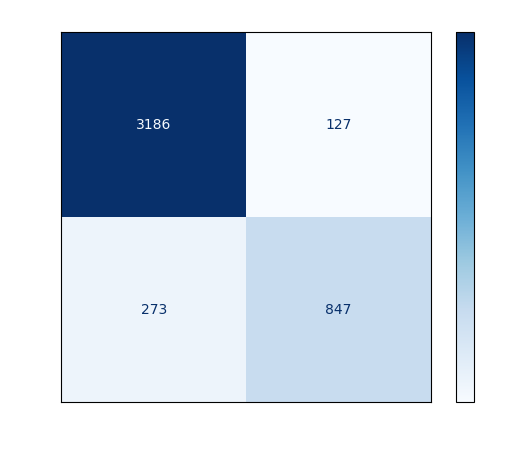

In [13]:
# aqui ainda não funciona
color = 'white'
matrix = plot_confusion_matrix(clf, x_test, y_test, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

In [141]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      4693
           1       1.00      0.99      0.99     17756

    accuracy                           0.99     22449
   macro avg       0.98      0.99      0.98     22449
weighted avg       0.99      0.99      0.99     22449

